### Import necessary packages

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import scipy.io.wavfile as wav
import scipy

from sklearn.model_selection import train_test_split

import os

##### Install dependencies and unzip dataset 

In [2]:
!pip install py7zr
!py7zr x '../input/tensorflow-speech-recognition-challenge/train.7z'
!py7zr x '../input/tensorflow-speech-recognition-challenge/test.7z'

     |████████████████████████████████| 66 kB 2.5 MB/s eta 0:00:011
     |████████████████████████████████| 124 kB 7.3 MB/s eta 0:00:01
     |███████████████████████████████▉| 2.2 MB 7.4 MB/s eta 0:00:01     |████████████████████████████████| 2.2 MB 7.4 MB/s 
     |████████████████████████████████| 1.9 MB 2.9 MB/s eta 0:00:01


### Create train-dataset

In [3]:
TRAIN_DIR = './train/audio'
labels = os.listdir(TRAIN_DIR)

Dataset of all labels except silence

In [ ]:
X = []
Y = []
for label in labels:
    print(label, end=", ")
    path = os.path.join(TRAIN_DIR, label)
    filenames = os.listdir(path)
    for filename in filenames:
        if ".wav" not in filename or label == "_background_noise_":
            continue
        audio, sr = librosa.load(os.path.join(path, filename))
        audio = audio[:sr:10]
        audio = np.pad(audio, (0, 2205-len(audio)), mode="constant", constant_values=0)
        audio = np.reshape(audio, (315,7)) # Reshaping samples to create dataset of shape (TIMESTEP, FEATURES)
        X.append(audio)
        Y.append(labels.index(label))

five, 

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


dog, _background_noise_, marvin, happy, seven, go, three, four, bird, bed, cat, tree, yes, zero, on, eight, right, stop, wow, sheila, off, 

Dataset creation of silence label

In [ ]:
label = "_background_noise_"
path = os.path.join(TRAIN_DIR, label)
filenames = os.listdir(path)
for filename in filenames:
    if ".wav" not in filename:
        continue
    audio, sr = librosa.load(os.path.join(path, filename))
    for i in range(0, sr, sr):
        a = audio[i:i+sr:10]
        a = np.pad(a, (0, 2205-len(a)), mode="constant", constant_values=0)
        a = np.reshape(a, (315,7))
        X.append(a)
        Y.append(labels.index(label))

In [ ]:
X = np.asarray(X)
Y = np.asarray(Y)
X.shape, Y.shape

### Train-Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

### Model Creation & Training

In [ ]:
def Model(X, dropout=0.4):
    _input = tf.keras.layers.Input(X)
    x = tf.keras.layers.Conv1D(64, 3, padding="same")(_input)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.MaxPool1D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.MaxPool1D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Conv1D(256, 3, padding="same")(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool1D()(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Activation(tf.nn.leaky_relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    x = tf.keras.layers.Dense(len(labels))(x)
    x = tf.keras.layers.Activation(tf.nn.softmax)(x)
    return tf.keras.Model(_input, x)

In [87]:
model = Model(x_train[0].shape)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
checkpoint_filepath = "weights_mfcc_Conv2D/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Summary of the output shape and parameters of the model

In [88]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 16)]         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
activation_35 (Activation)   (None, 100, 64)           0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 100, 64)           256       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 128)           2470

In [91]:
H = model.fit(x_train, y_train, batch_size=128, epochs=500, validation_split=0.25, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/500
287/287 [==============================] - 3s 10ms/step - loss: 1.2174 - accuracy: 0.6392 - val_loss: 1.6416 - val_accuracy: 0.5505
Epoch 2/500
287/287 [==============================] - 3s 9ms/step - loss: 1.2175 - accuracy: 0.6381 - val_loss: 1.7376 - val_accuracy: 0.5365
Epoch 3/500
287/287 [==============================] - 3s 10ms/step - loss: 1.2117 - accuracy: 0.6398 - val_loss: 1.5391 - val_accuracy: 0.5534
Epoch 4/500
287/287 [==============================] - 3s 9ms/step - loss: 1.2176 - accuracy: 0.6380 - val_loss: 2.8696 - val_accuracy: 0.3154
Epoch 5/500
287/287 [==============================] - 3s 9ms/step - loss: 1.2102 - accuracy: 0.6410 - val_loss: 1.6887 - val_accuracy: 0.5354
Epoch 6/500
287/287 [==============================] - 3s 9ms/step - loss: 1.2079 - accuracy: 0.6397 - val_loss: 1.7844 - val_accuracy: 0.5073
Epoch 7/500
287/287 [==============================] - 3s 10ms/step - loss: 1.2132 - accuracy: 0.6416 - val_loss: 2.0316 - val_accuracy: 0.4

KeyboardInterrupt: 

Plot of the train history (X-axis: <i>EPOCHS</i>, Y-axis: <i>ACCURACY</i>)

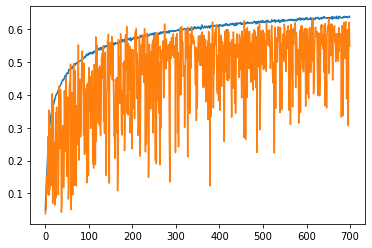

In [90]:
plt.plot(H.history["accuracy"])
plt.plot(H.history["val_accuracy"])

Load the best weights and evaluate the model

In [92]:
model.load_weights("weights_mfcc_Conv2D/")
model.evaluate(x_test, y_test)

509/509 [==============================] - 1s 3ms/step - loss: 1.2941 - accuracy: 0.6433


[1.2941157817840576, 0.6433265805244446]